In [26]:
!pip install noisereduce

Defaulting to user installation because normal site-packages is not writeable
  Using cached noisereduce-1.1.0.tar.gz (6.3 kB)
  Created wheel for noisereduce: filename=noisereduce-1.1.0-py3-none-any.whl size=7608 sha256=8183c6c34980b15fe81f29f1f4bb8870a920f1c4452bbea8ea2b7ca04f537cfc
  Stored in directory: /home/user/.cache/pip/wheels/a9/d4/51/49c94295d30569d64c83dc11dce56166173635c85d060c9859
Successfully built noisereduce


In [1]:
import IPython.display
import soundfile as sf
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import maximum_filter1d
import scipy

In [2]:
wav_path = '/home/knikaido/work/tmp/noise_reduce/sample.wav'

# ノイズ除去モジュールの紹介

現実で集音された音は，たくさんノイズが乗っていることが少なくありません． <br>
例えば，以下の音源では，背景音として「サーッ」というノイズが常に乗っています．

In [3]:
wav, sr = sf.read(wav_path)
IPython.display.Audio(wav, rate=sr)

スペクトログラムでも確認してみましょう．

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


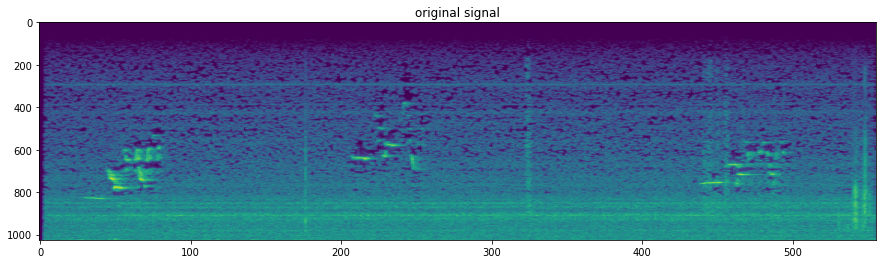

In [4]:
S = librosa.stft(wav)
S = librosa.power_to_db(np.abs(S)**2).astype(np.float32)

plt.figure(figsize=(15,4))
plt.title('original signal')
plt.imshow(np.flipud(S))
plt.axes().set_aspect('auto')

## 1. HPSS
HPSSとは，スペクトログラムにおいて，調波音成分は時間軸方向に，非調波音成分は周波数軸方向に連続性が強いということに着目し，それらを分離する手法です．

In [5]:
%time
wav_harm, wav_perc = librosa.effects.hpss(wav, margin=(1.0, 3.0))

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


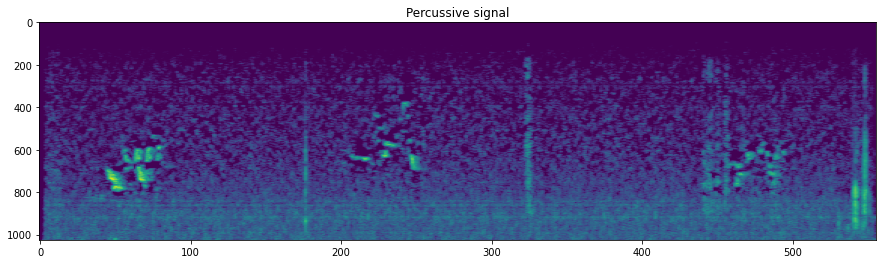

In [6]:
S_perc = librosa.stft(wav_perc)
S_perc = librosa.power_to_db(np.abs(S_perc)**2).astype(np.float32)

plt.figure(figsize=(15,4))
plt.title('Percussive signal')
plt.imshow(np.flipud(S_perc))
plt.axes().set_aspect('auto')

IPython.display.Audio(wav_perc, rate=sr)

## 2. スペクトラルノイズ除去


ここでは，スペクトラルノイズ除去という方法を紹介します． <br>
スペクトラルノイズ除去では，Sound Envelopというものを用いてノイズ成分を特定し，除去します． <br>
まずは，Sound Envelopを算出してみましょう．具体的には，元信号の振幅レベルの高いところを抽出します．

In [7]:
def envelope(y, rate, threshold):
    mask = []
    y_mean = maximum_filter1d(np.abs(y), mode="constant", size=rate//20)
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

In [8]:
thr = 0.5
mask, env = envelope(wav, sr, thr)

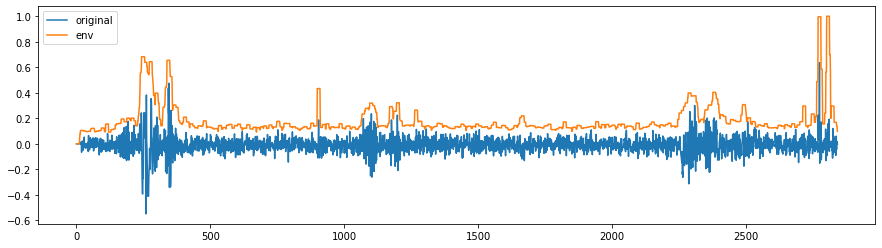

In [9]:
plt.figure(figsize=(15,4))
plt.plot(wav[::100], label='original')
plt.plot(env[::100], label='env')
plt.legend()

これを用いて，Sound Envelopに寄与していない部分をマスクします． <br>
少し具体的に話すと，<br>
1. ノイズ成分のみの信号をstftし，各周波数帯のノイズの閾値を算出します．
2. 元信号に置いて，閾値以下の信号をマスクします．

In [10]:
n_grad_freq = 2  # マスクで平滑化する周波数チャンネルの数
n_grad_time = 4  # マスクを使って滑らかにする時間チャンネル数
prop_decrease = 1.0  # ノイズをどの程度減らすか
n_std_thresh=1.5 
def _stft(y):
    return librosa.stft(y=y)

def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)

In [11]:
noise_stft = _stft(wav[np.logical_not(mask)])
noise_stft_db = _amp_to_db(np.abs(noise_stft))  # dBに変換する
   
mean_freq_noise = np.mean(noise_stft_db, axis=1)
std_freq_noise = np.std(noise_stft_db, axis=1)
noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh

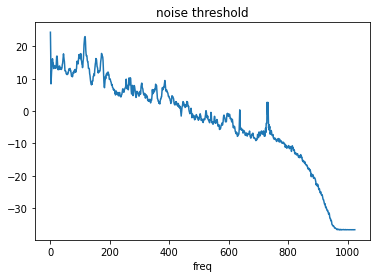

In [18]:
plt.title('noise threshold')
plt.xlabel('freq')
plt.plot(noise_thresh)

上が，各周波数帯でのノイズの閾値です．

In [20]:
# 音源もSTFTで特徴量抽出する
sig_stft = _stft(wav)
sig_stft_db = _amp_to_db(np.abs(sig_stft))

# 時間と周波数のしきい値の計算
db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
sig_mask = sig_stft_db < db_thresh


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


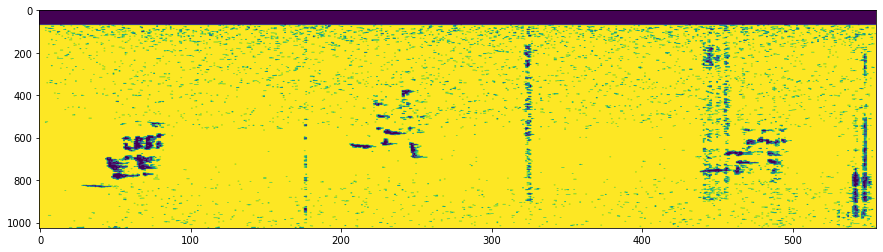

In [21]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(sig_mask))
plt.axes().set_aspect('auto')

In [22]:
# 時間と頻度でマスクの平滑化フィルターを作成
smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
smoothing_filter = smoothing_filter / np.sum(smoothing_filter)

In [23]:
sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
sig_mask = sig_mask * prop_decrease

mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))

def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)

sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


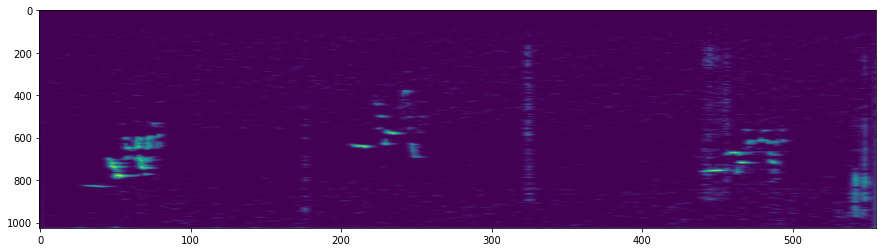

In [24]:
plt.figure(figsize=(15,4))
plt.imshow(np.flipud(sig_stft_db_masked))
plt.axes().set_aspect('auto')

以上が，スペクトラルノイズ除去のざっくりした流れになります． <br>
つぎに，これをラッパーしたモジュールを紹介します．__noisereduce__というこのモジュールは，上記の流れを一発でやってくれます．

In [27]:
import noisereduce as nr

/home/user/.local/lib/python3.6/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 19.6 µs


  0%|          | 0/7 [00:00<?, ?it/s]

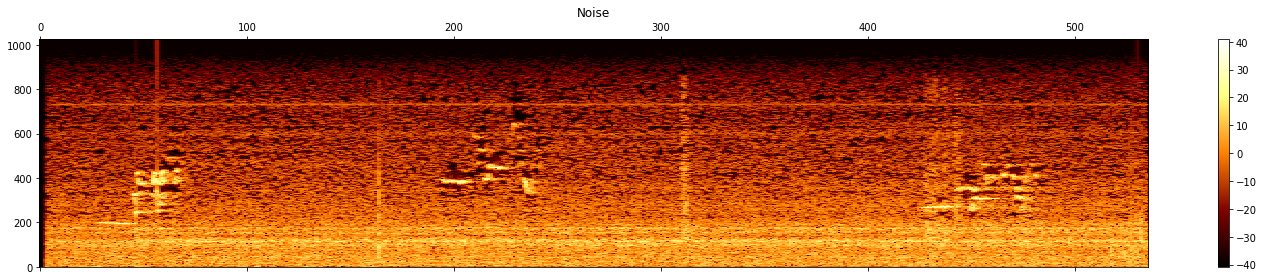

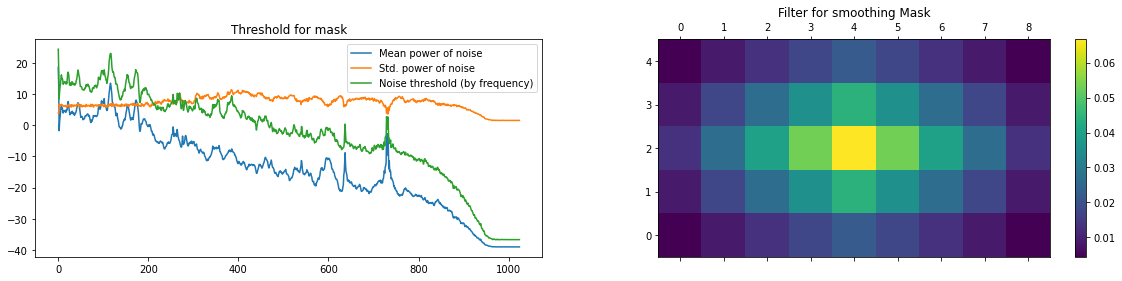

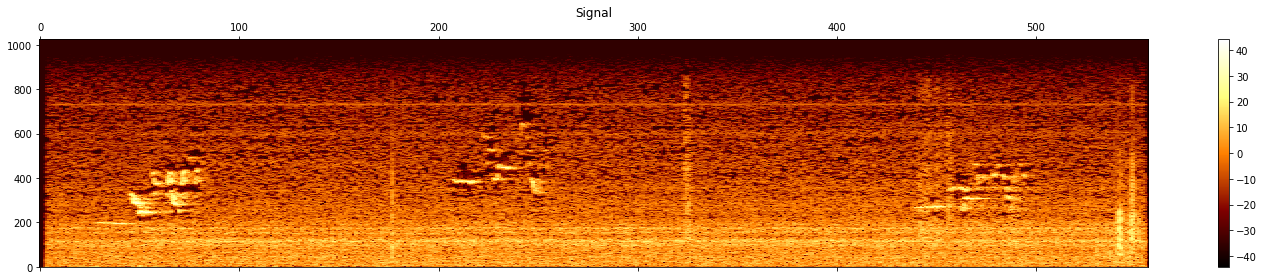

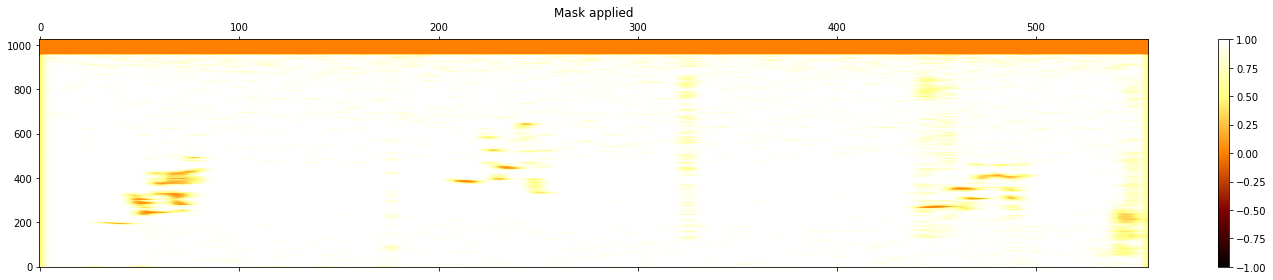

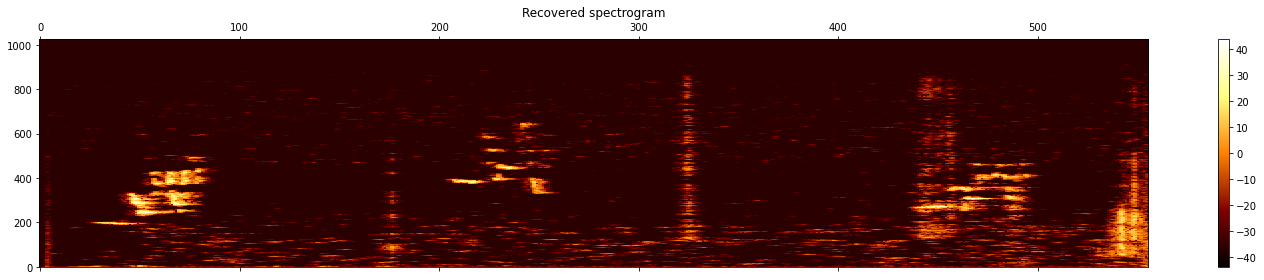

In [28]:
%time
thr = 0.5
mask, env = envelope(wav, sr, thr)
wav_denoise = nr.reduce_noise(audio_clip=wav, noise_clip=wav[np.logical_not(mask)], verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


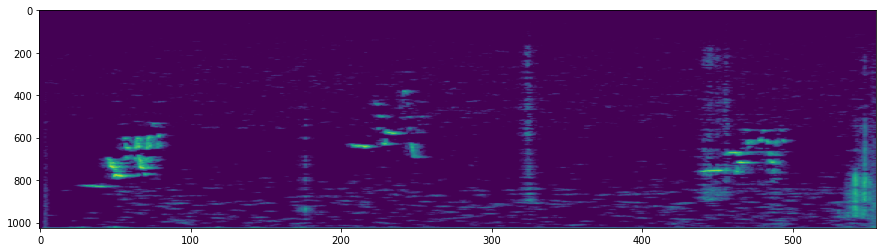

In [29]:
S_denoise = librosa.stft(wav_denoise)
S_denoise = librosa.power_to_db(np.abs(S_denoise)**2).astype(np.float32)

plt.figure(figsize=(15,4))
plt.imshow(np.flipud(S_denoise))
plt.axes().set_aspect('auto')

IPython.display.Audio(wav_denoise, rate=sr)

最後に，オリジナルと，hpssと，このnoisereduceを比較して終わりたいと思います． <br>
突発音のノイズはの除去はこの方法では難しいですが，定常的なノイズを消したい場面では有用な方法だと思います． <br>
ぜひ使ってみてください．

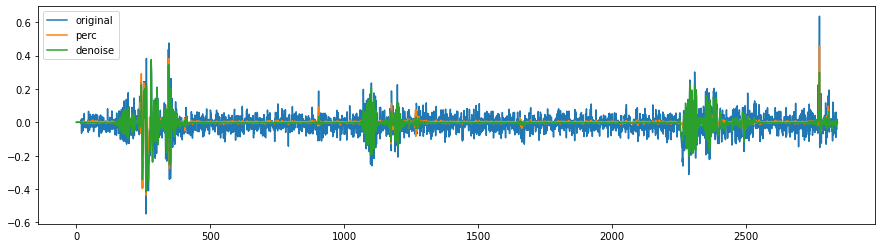

In [30]:
plt.figure(figsize=(15,4))
plt.plot(wav[::100], label='original')
plt.plot(wav_perc[::100], label='perc')
plt.plot(wav_denoise[::100], label='denoise')
plt.legend()

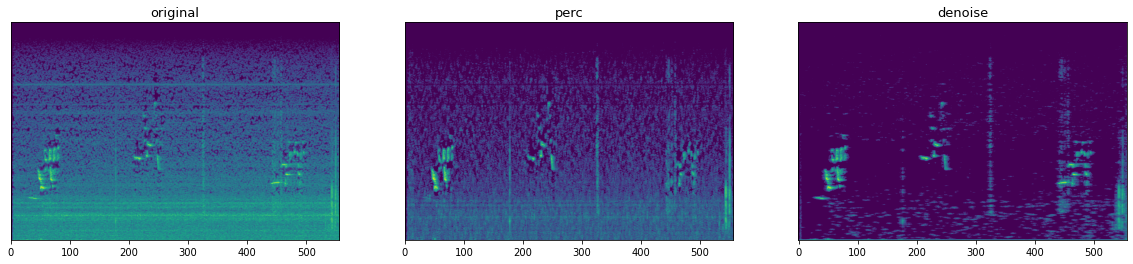

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# plt.subplots_adjust(wspace=0.1)
ax[0].imshow(np.flipud(S))
ax[1].imshow(np.flipud(S_perc))
ax[2].imshow(np.flipud(S_denoise))

anom_name = ['original', 'perc', 'denoise']
for i in range(0, 3):
    ax[i].set_title(anom_name[i], fontsize=13)
    ax[i].set_aspect(aspect='auto')
    ax[i].axes.yaxis.set_visible(False)

参考
- https://pypi.org/project/noisereduce/
- https://www.ai-shift.co.jp/techblog/1305